#Comparing Various Models for Multi-Class Classification for NLP Based Task

###Author - Harsh Sharma


#Importing Important Libraries :

In [ ]:
#Importing Important Libraries :
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional,Conv1D,MaxPool1D,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
import re
nltk.download('punkt')

!pip install prettytable
from prettytable import PrettyTable


import time



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Getting Dataset :
!wget --no-check-certificate \
    https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2021-03-18 11:48:09--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2021-03-18 11:48:09 (105 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
#Converting Dataset to Dataframe :
articles = []
labels = []

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


In [ ]:
raw_df=pd.DataFrame({"Text":articles,"Labels":labels})
raw_df

,Text,Labels
0,tv future hands viewers home theatre systems ...,tech
1,worldcom boss left books alone former worldc...,business
2,tigers wary farrell gamble leicester say rus...,sport
3,yeading face newcastle fa cup premiership side...,sport
4,ocean twelve raids box office ocean twelve cr...,entertainment
...,...,...
2220,cars pull us retail figures us retail sales fe...,business
2221,kilroy unveils immigration policy ex-chatshow ...,politics
2222,rem announce new glasgow concert us band rem a...,entertainment
2223,how political squabbles snowball become common...,politics


In [ ]:
#Inspecting our Dataframe :
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
#Getting Number of Unique Classes in our dataset :
raw_df.Labels.unique(),print("\n Total number of Unique Target Classes : ",raw_df.Labels.nunique())


 Total number of Unique Target Classes :  5


(array(['tech', 'business', 'sport', 'entertainment', 'politics'],
       dtype=object), None)

In [ ]:
# Text cleanup :
stemmer = PorterStemmer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

In [ ]:
dataset=raw_df

In [ ]:
dataset['Text']=dataset['Text'].apply(clean_text)
dataset['Text']

0       tv futur hand viewer home theatr system plasma...
1       worldcom boss left book alon former worldcom b...
2       tiger wari farrel gambl leicest say rush make ...
3       yead face newcastl fa cup premiership side new...
4       ocean twelv raid bo offic ocean twelv crime ca...
                              ...                        
2220    car pull us retail figur us retail sale fell j...
2221    kilroy unveil immigr polici echatshow host rob...
2222    rem announc new glasgow concert us band rem an...
2223    polit squabbl snowbal becom commonplac argu bl...
2224    souness delight euro progress boss graem soune...
Name: Text, Length: 2225, dtype: object

In [ ]:
#Splitting raw data for Training and Testing :
text = dataset["Text"].values
labels = dataset['Labels'].values

X_train, y_train, X_test, y_test = train_test_split(text,labels, test_size = 0.20, random_state = 42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780,)
(445,) (445,)


In [ ]:
#Reshaping Labels Input :
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(1780,) (1780, 1)
(445,) (445, 1)


In [ ]:
# Tokenising , Converting Text To Sequences and Padding Our Data : 

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index

Found 19057 unique tokens.


{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'year': 4,
 'would': 5,
 'also': 6,
 'new': 7,
 'peopl': 8,
 'us': 9,
 'one': 10,
 'game': 11,
 'say': 12,
 'use': 13,
 'could': 14,
 'time': 15,
 'last': 16,
 'make': 17,
 'first': 18,
 'net': 19,
 'go': 20,
 'govern': 21,
 'like': 22,
 'two': 23,
 'play': 24,
 'take': 25,
 'world': 26,
 'get': 27,
 'compani': 28,
 'film': 29,
 'work': 30,
 'uk': 31,
 'show': 32,
 'firm': 33,
 'music': 34,
 'back': 35,
 'bn': 36,
 'want': 37,
 'best': 38,
 'told': 39,
 'market': 40,
 'win': 41,
 'plan': 42,
 'made': 43,
 'includ': 44,
 'month': 45,
 'report': 46,
 'servic': 47,
 'set': 48,
 'come': 49,
 'number': 50,
 'ad': 51,
 'way': 52,
 'player': 53,
 'week': 54,
 'three': 55,
 'countri': 56,
 'need': 57,
 'mani': 58,
 'parti': 59,
 'bbc': 60,
 'labour': 61,
 'look': 62,
 'epect': 63,
 'home': 64,
 'elect': 65,
 'may': 66,
 'nation': 67,
 'sale': 68,
 'good': 69,
 'help': 70,
 'day': 71,
 'well': 72,
 'call': 73,
 'minist': 74,
 'technolog': 75,
 'million': 76,


In [ ]:
# Converting into Text to sequences and padding :
train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_seq = tokenizer.texts_to_sequences(y_train)
validation_padded = pad_sequences(validation_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
#Just an Example to see the raw sentance , sentance in sequences, sentance in sequences with padding:
X_train[3],train_seq[3],train_padded[3]

('school tribut tv host carson peopl turn sunday pay tribut late us tv present johnni carson nebraska town grew carson host tonight show year die januari respiratori diseas emphysema live norfolk nebraska age eight join navi return regularli donat local caus old school friend among crowd school johnni carson theater carson one bestlov tv person us ask public memori lo angel live later life began showbusi career norfolk perform magic name great carsoni age donat includ norfolk high school build new perform art centr carson die presid bush led public tribut say present profound influenc american life entertain',
 [406,
  1949,
  118,
  533,
  4422,
  8,
  256,
  400,
  263,
  1949,
  671,
  9,
  118,
  414,
  2424,
  4422,
  7885,
  2002,
  1396,
  4422,
  533,
  5529,
  32,
  4,
  788,
  314,
  12214,
  1915,
  12215,
  210,
  4423,
  7885,
  480,
  688,
  534,
  7886,
  188,
  2140,
  1054,
  395,
  613,
  689,
  406,
  879,
  429,
  1103,
  406,
  2424,
  4422,
  9366,
  4422,
  10,
 

In [ ]:
print('Shape of data tensor:', train_padded.shape)
print('Shape of data tensor:', validation_padded.shape)

Shape of data tensor: (1780, 200)
Shape of data tensor: (445, 200)


In [ ]:
#Using One Hot Enocder to Enocde our Multi class Labels  :
encode = OneHotEncoder()

training_labels = encode.fit_transform(X_test)
validation_labels = encode.transform(y_test)

In [ ]:
print(train_padded.shape)
print(validation_labels.shape)
print(validation_padded.shape)
print(training_labels.shape)
print(type(train_padded))
print(type(validation_padded))
print(type(training_labels))
print(type(validation_labels))



# The labels must be converted to arrays
# Convert the labels to arrays
training_labels = training_labels.toarray()
validation_labels = validation_labels.toarray()

print(type(training_labels))
print(type(validation_labels))


(1780, 200)
(445, 5)
(445, 200)
(1780, 5)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Basic Functions for Plotting and Evaluation :

In [ ]:
def plot_graphs(history):
  plt.title('Loss VS Accuracy')
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='test loss')
  plt.legend()
  
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='test accuracy')
  plt.legend()
  plt.show();
  return None
def loss_graph(history):
  plt.title('Loss')
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show();

  return None

def acc_graph(history):
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.legend()
  plt.show();

  return None


def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='micro')
    recall = recall_score(y_true, y_preds, average='micro')
    f1 = f1_score(y_true, y_preds, average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1

def model_eval(model,a,b,c,d):
  score=model.evaluate(a,b,verbose=0)
  score1=model.evaluate(c,d,verbose=0)
  print("\n")
  print("Model Loss on training data ",score[0])
  print("Model Accuracy on training data: ",score[1])
  print("Model Loss on validation data",score1[0])
  print("Model Accuracy on validation data: ",score1[1])
  print("\n")
  return score,score1



  

## Model Architectures :

In [ ]:
#Let's Fix Some Common Parameters :
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

1. Using Conv1D :

In [ ]:



model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=train_padded.shape[1]))

model.add(Conv1D(48, 5, activation='relu', padding='valid'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 100
batch_size = 32
filepath="weights_best_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
start = time.perf_counter()
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)]


history = model.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)
hist1=history


Epoch 1/100
56/56 [==============================] - 8s 125ms/step - loss: 1.6091 - accuracy: 0.2153 - val_loss: 1.5164 - val_accuracy: 0.4764

Epoch 00001: val_accuracy improved from -inf to 0.47640, saving model to weights_best_cnn.hdf5
Epoch 2/100
56/56 [==============================] - 7s 121ms/step - loss: 1.4508 - accuracy: 0.4141 - val_loss: 1.2887 - val_accuracy: 0.7596

Epoch 00002: val_accuracy improved from 0.47640 to 0.75955, saving model to weights_best_cnn.hdf5
Epoch 3/100
56/56 [==============================] - 7s 122ms/step - loss: 1.2067 - accuracy: 0.5683 - val_loss: 0.9165 - val_accuracy: 0.8584

Epoch 00003: val_accuracy improved from 0.75955 to 0.85843, saving model to weights_best_cnn.hdf5
Epoch 4/100
56/56 [==============================] - 7s 120ms/step - loss: 0.9299 - accuracy: 0.7063 - val_loss: 0.6309 - val_accuracy: 0.8876

Epoch 00004: val_accuracy improved from 0.85843 to 0.88764, saving model to weights_best_cnn.hdf5
Epoch 5/100
56/56 [================

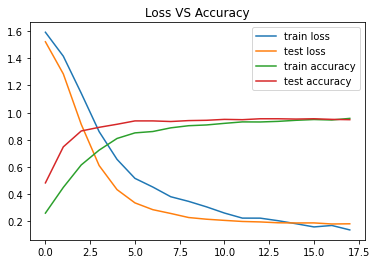

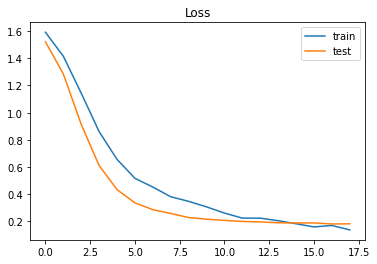

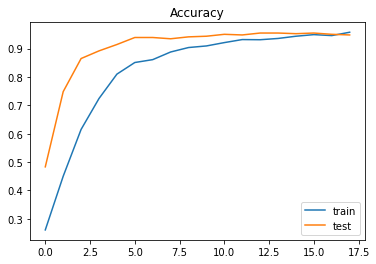

(None, None, None)

In [ ]:
plot_graphs(hist1),loss_graph(hist1),acc_graph(hist1)

In [ ]:
# Now we make predictions using the test data to see how the model performs

predicted = model.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))


Acc: 94.83%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

In [ ]:
# Testing Random Text and Predicted Classes :

original_text=raw_df['Text']
text = original_text[18]
new_text = [clean_text(text)]
print(text)
print(new_text)
seq = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(padded)
acc = model.predict_proba(padded)
predicted_label = encode.inverse_transform(pred)
print('')
print(f'Product category id: {np.argmax(pred[0])}')
print(f'Predicted label is: {predicted_label[0]}')
print(f'Accuracy score: { acc.max() * 100}')

japanes bank battl end japan sumitomo mitsui financi withdrawn takeov offer rival bank ufj hold enabl latter merg mitsubishi tokyo sumitomo boss told counterpart ufj decis friday clear way conclud trillion yen bn deal mitsubishi deal would creat world biggest bank asset trillion yen trillion sumitomo eit end high profil fight japanes bank histori ufj hold japan fourthlargest bank centr fierc bid battl last year sumitomo japan thirdlargest bank tabl higher offer ufj rival valu compani bn howev ufj manag known prefer offer mitsubishi tokyo financi group mtfg japan secondlargest bank concern also rais sumitomo abil absorb ufj former admit defeat believ market investor accept ufjmtfg merger sumitomo said statement given ongo integr ufj mtfg oper persist propos may best interest sharehold ufj mitsubishi takeov ufj japan largestev takeov deal still approv sharehold two firm howev epect formal sumitomo may turn attent deepen tie daiwa secur anoth japanes financi firm two set merg ventur capit

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


2.Using LSTMs :

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


model2 = Sequential()

model2.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model2.add(Dropout(0.5))
model2.add(LSTM(embedding_dim))
model2.add(Dense(5, activation='softmax'))

model2.summary()

model2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 100
batch_size = 32
filepath="weights_best_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)]


history2 = model2.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
hist2=history2

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 128)          6400000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 6,532,229
Trainable params: 6,532,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 17s 271ms/step - loss: 1.5505 - accuracy: 0.2787 - val_loss: 1.1930 - val_accuracy: 0.3955

Epoch 00001: val_accuracy improved from -inf to 0.39551, saving model to weights_best_lstms.hdf5

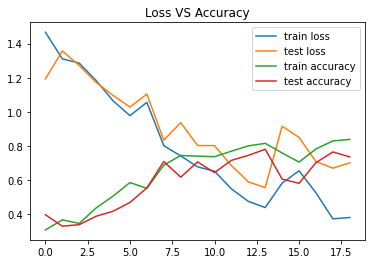

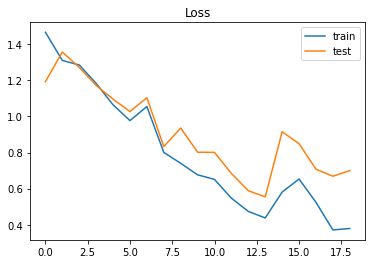

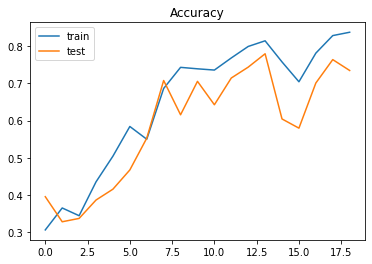

(None, None, None)

In [ ]:
plot_graphs(hist2),loss_graph(hist2),acc_graph(hist2)

In [ ]:
predicted = model2.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 73.48%
Precision: 0.73
Recall: 0.73
F1 score: 0.73


{'accuracy': 0.73, 'f1': 0.73, 'precision': 0.73, 'recall': 0.73}

3.Using Bi-Directional LSTMs :

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


model3 = Sequential()

model3.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model3.add(Dropout(0.5))
model3.add(Bidirectional(LSTM(embedding_dim)))
model3.add(Dense(5, activation='softmax'))

model3.summary()

model3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 100
batch_size = 32
filepath="weights_best_bi_lstms.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)]


history3 = model3.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
hist3=history3

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 128)          6400000   
_________________________________________________________________
dropout_15 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 6,664,453
Trainable params: 6,664,453
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 31s 502ms/step - loss: 1.5314 - accuracy: 0.2994 - val_loss: 1.0781 - val_accuracy: 0.6180

Epoch 00001: val_accuracy improved from -inf to 0.61798, saving model to weights_best_bi_lstms.h

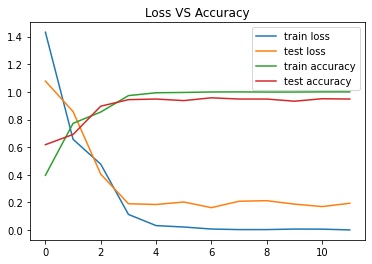

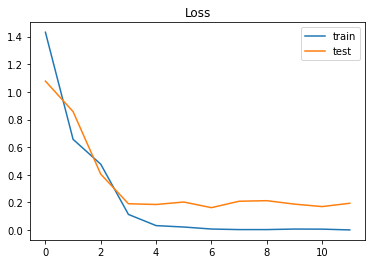

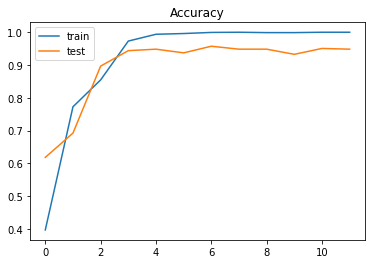

(None, None, None)

In [ ]:
plot_graphs(hist3),loss_graph(hist3),acc_graph(hist3)

In [ ]:
predicted = model3.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 94.83%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

4.Using CNN1D + LSTMs :

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


model4 = Sequential()

model4.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model4.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model4.add(MaxPooling1D(pool_size=2))
model4.add(LSTM(embedding_dim))
model4.add(Dense(5, activation='softmax'))

model4.summary()

model4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 100
batch_size = 32
filepath="weights_best_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)]


history4 = model4.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
hist4=history4

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 128)          6400000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               82432     
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 6,495,397
Trainable params: 6,495,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 11s 169ms/step - loss: 1.4896 - accuracy: 0.3068 - val_l

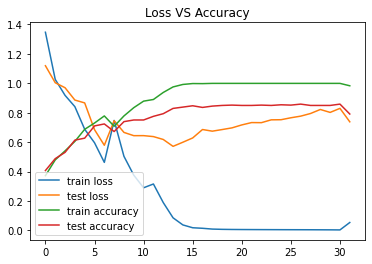

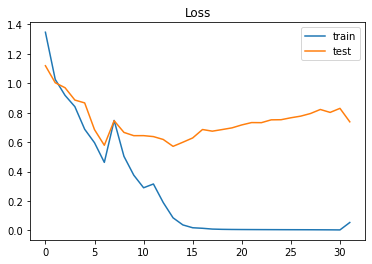

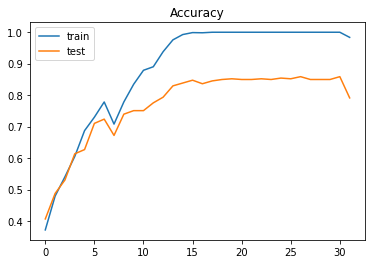

(None, None, None)

In [ ]:
plot_graphs(hist4),loss_graph(hist4),acc_graph(hist4)

In [ ]:
predicted = model4.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 79.10%
Precision: 0.79
Recall: 0.79
F1 score: 0.79


{'accuracy': 0.79, 'f1': 0.79, 'precision': 0.79, 'recall': 0.79}

5.Using Bi_LSTMs + CNN1D :

In [ ]:
# The maximum number of words to be used. (most frequent)
vocab_size = 50000

# Dimension of the dense embedding.
embedding_dim = 128

# Max number of words in each complaint.
max_length = 200

# Truncate and padding options
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'


model5 = Sequential()

model5.add(Embedding(vocab_size, embedding_dim,input_length=train_padded.shape[1]))
model5.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Bidirectional(LSTM(embedding_dim)))
model5.add(Dense(5, activation='softmax'))

model5.summary()

model5.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

epochs = 100
batch_size = 32
filepath="weights_best_bi_lstms_n_cnn.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint,EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1)]


history5 = model5.fit(train_padded, training_labels, shuffle=True ,
                    epochs=epochs, batch_size=batch_size, 
                    callbacks=callbacks_list,validation_data=(validation_padded, validation_labels))
hist5=history5

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 128)          6400000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               164864    
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 1285      
Total params: 6,578,469
Trainable params: 6,578,469
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
56/56 [==============================] - 16s 232ms/step - loss: 1.5235 - accuracy: 0.2695 - val_l

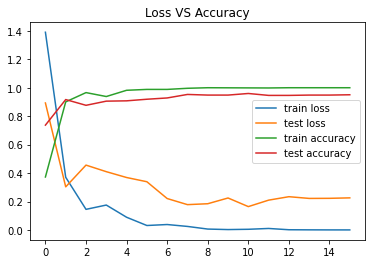

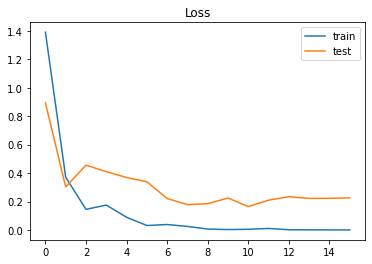

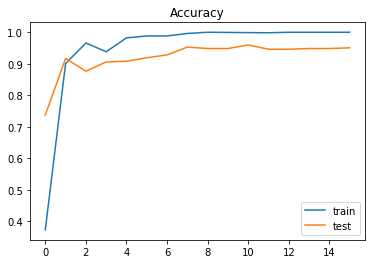

(None, None, None)

In [ ]:
plot_graphs(hist5),loss_graph(hist5),acc_graph(hist5)

In [ ]:
predicted = model5.predict(validation_padded)
evaluate_preds(np.argmax(validation_labels, axis=1), np.argmax(predicted, axis=1))

Acc: 95.06%
Precision: 0.95
Recall: 0.95
F1 score: 0.95


{'accuracy': 0.95, 'f1': 0.95, 'precision': 0.95, 'recall': 0.95}

## Overall Evaluation of all Models

In [ ]:
print("Final Performance Of All Models : \n")
print("Model 1 - CNN-1D \n")
mod1=model_eval(model,train_padded,training_labels,validation_padded,validation_labels)
print("Model 2 - LSTM \n")
mod2=model_eval(model2,train_padded,training_labels,validation_padded,validation_labels)
print("Model 3 - Bidirectional LSTM \n")
mod3=model_eval(model3,train_padded,training_labels,validation_padded,validation_labels)
print("Model 4 - CNN-1D + LSTM \n")
mod4=model_eval(model4,train_padded,training_labels,validation_padded,validation_labels)
print("Model 5 - CNN-1D + Bidirectional LSTM \n")
mod5=model_eval(model5,train_padded,training_labels,validation_padded,validation_labels)

Final Performance Of All Models : 

Model 1 - CNN-1D 



Model Loss on training data  0.0061076246201992035
Model Accuracy on training data:  1.0
Model Loss on validation data 0.1820492148399353
Model Accuracy on validation data:  0.9483146071434021


Model 2 - LSTM 



Model Loss on training data  0.4365732669830322
Model Accuracy on training data:  0.8162921071052551
Model Loss on validation data 0.6999689936637878
Model Accuracy on validation data:  0.7348314523696899


Model 3 - Bidirectional LSTM 



Model Loss on training data  0.0007607854204252362
Model Accuracy on training data:  1.0
Model Loss on validation data 0.19389493763446808
Model Accuracy on validation data:  0.9483146071434021


Model 4 - CNN-1D + LSTM 



Model Loss on training data  0.08141876757144928
Model Accuracy on training data:  0.9797753095626831
Model Loss on validation data 0.7380450367927551
Model Accuracy on validation data:  0.7910112142562866


Model 5 - CNN-1D + Bidirectional LSTM 



Model Loss on t

In [ ]:


table = PrettyTable()
table.field_names = ['Model', 'Accuracy']
table.add_row(['CNN-1D',round(mod1[1][1]*100,2)])
table.add_row(['LSTM', round(mod2[1][1]*100,2)])
table.add_row(['Bidirectional LSTM', round(mod3[1][1]*100,2)])
table.add_row(['CNN-1D + LSTM', round(mod4[1][1]*100,2)])
table.add_row(['CNN-1D + Bidirectional LSTM', round(mod5[1][1]*100,2)])
print(table)

+-----------------------------+----------+
|            Model            | Accuracy |
+-----------------------------+----------+
|            CNN-1D           |  94.83   |
|             LSTM            |  73.48   |
|      Bidirectional LSTM     |  94.83   |
|        CNN-1D + LSTM        |   79.1   |
| CNN-1D + Bidirectional LSTM |  95.06   |
+-----------------------------+----------+


#Link For References :

1. https://ruder.io/deep-learning-nlp-best-practices/#:~:text=Optimization%20algorithm%20Adam%20(Kingma%20%26%20Ba,stochastic%20gradient%20descent%20(SGD).
2. https://colah.github.io/posts/2015-08-Understanding-LSTMs/
3. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
4. https://www.jeansnyman.com/posts/multi-class-text-classification-with-tensorflow/